In [52]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import xgboost as xgb
from sklearn.impute import KNNImputer, SimpleImputer
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import spearmanr
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
import re
from scipy.stats import randint
from scipy.stats import spearmanr
import plotly.express as px
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/novozymes-enzyme-stability-prediction/sample_submission.csv
/kaggle/input/novozymes-enzyme-stability-prediction/wildtype_structure_prediction_af2.pdb
/kaggle/input/novozymes-enzyme-stability-prediction/train.csv
/kaggle/input/novozymes-enzyme-stability-prediction/test.csv
/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv


# Data Preparation

In [30]:
# Will take 3-5 seconds to run
def load_fixed_train_df(original_train_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train.csv",
                        update_file_path="/kaggle/input/novozymes-enzyme-stability-prediction/train_updates_20220929.csv",
                        was_fixed_col=False):
    def _fix_tm_ph(_row, update_map):
        update_vals = update_map.get(_row["seq_id"], None)
        if update_vals is not None:
            _row["tm"] = update_vals["tm"]
            _row["pH"] = update_vals["pH"]
        return _row

    # Load dataframes
    _df = pd.read_csv(original_train_file_path)
    _updates_df = pd.read_csv(update_file_path)

    # Identify which sequence ids need to have the tm and pH values changed and create a dictionary mapping 
    seqid_2_phtm_update_map = _updates_df[~pd.isna(_updates_df["pH"])].groupby("seq_id")[["pH", "tm"]].first().to_dict("index")

    # Identify the sequence ids that will be dropped due to data quality issues
    bad_seqids = _updates_df[pd.isna(_updates_df["pH"])]["seq_id"].to_list()

    # Fix bad sequence ids
    _df = _df[~_df["seq_id"].isin(bad_seqids)].reset_index(drop=True)

    # Fix pH and tm swaparoo
    _df = _df.apply(lambda x: _fix_tm_ph(x, seqid_2_phtm_update_map), axis=1)

    # Add in a bool to track if a row was fixed or not (tm/ph swap will look the same as bad data)
    if was_fixed_col: _df["was_fixed"] = _df["seq_id"].isin(bad_seqids+list(seqid_2_phtm_update_map.keys()))

    return _df

In [31]:
# Load the Fixed Train dataframe
train_df = load_fixed_train_df()
test_df = pd.read_csv("../input/novozymes-enzyme-stability-prediction/test.csv")
sub_df = pd.read_csv("../input/novozymes-enzyme-stability-prediction/sample_submission.csv")

In [32]:
train_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
0,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
5,5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.4
6,6,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,doi.org/10.1038/s41592-020-0801-4,45.7
7,7,AAENRPPIPGSLGMLYDSTLCVGCQACVTKCQDINFPERNPQGEQT...,7.0,doi.org/10.1038/s41592-020-0801-4,55.9
8,8,AAEYAVVLKTLSNPFWVDMKKGIEDEAKTLGVSVDIFASPSEGDFQ...,7.0,doi.org/10.1038/s41592-020-0801-4,48.1
9,9,AAFQVTSNEIKTGEQLTTSHVFSGFGCEGGNTSPSLTWSGVPEGTK...,7.0,doi.org/10.1038/s41592-020-0801-4,49.7


In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28981 entries, 0 to 28980
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   seq_id            28981 non-null  int64  
 1   protein_sequence  28981 non-null  object 
 2   pH                28695 non-null  float64
 3   data_source       28001 non-null  object 
 4   tm                28981 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 1.1+ MB


In [34]:
# Split the data into train and validation set
train_df, val_df = train_test_split(train_df, test_size=0.33, random_state=42)

# Exploratory Data Analysis

In [35]:
train_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                  202
data_source         640
tm                    0
dtype: int64

In [36]:
val_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                   84
data_source         340
tm                    0
dtype: int64

In [37]:
train_df.describe()

,seq_id,pH,tm
count,19417.000000,19215.000000,19417.000000
mean,15743.843076,6.871911,51.387480
std,9281.762946,0.796212,12.105179
min,0.000000,1.990000,25.100000
25%,7463.000000,7.000000,43.600000
50%,15570.000000,7.000000,48.800000
75%,23939.000000,7.000000,54.600000
max,31389.000000,11.000000,130.000000


In [38]:
train_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
12058,12819,MINSPRVCIQVQSVYIEAQSSPDNERYVFAYTVTIRNLGRAPVQLL...,7.0,doi.org/10.1038/s41592-020-0801-4,46.6
2381,2430,LDEKVDEMTGYQAEAKMTFRTGEKPQVYHVEVWHKQPSYYRVSLKN...,7.0,doi.org/10.1038/s41592-020-0801-4,78.9
6381,6620,MATDNLISKIKNRESGIVLYGITPPKKGTSEEKITEISARQVDRLQ...,7.0,doi.org/10.1038/s41592-020-0801-4,36.9
10739,11376,MGIGSKILENNIQKSISLGFYHSHSELRKSFYEFFKSKNHEILRSS...,7.0,doi.org/10.1038/s41592-020-0801-4,36.2
21911,24093,MSIDRTSPLKPVSTVQPRETTDAPVTNSRAAKTTASTSTSVTLSDA...,7.0,doi.org/10.1038/s41592-020-0801-4,61.5
19602,21628,MRATQFLIATVKETPTDAVVISHQLMLRAGMIRKLASGLYTWLPLG...,7.0,doi.org/10.1038/s41592-020-0801-4,40.8
110,124,AEGFVVKDIHFEGLQRVAVGAALLSMPVRTGDTVNDEDISNTIRAL...,7.0,doi.org/10.1038/s41592-020-0801-4,53.5
5743,5977,MARKQQFDYNEDAIQVLEGLEAVRKRPGMYIGSTDARGLHHLVYEI...,7.0,doi.org/10.1038/s41592-020-0801-4,42.4
12475,13398,MKALIVLGLVLLSVTVQGKVFERCELARTLKRLGMDGYRGISLANW...,2.7,10.1006/jmbi.1998.1906,44.8
6678,6942,MATYLEFIQQNEERDGVRFSWNVWPSSRLEATRMVVPLACLLTPLK...,7.0,doi.org/10.1038/s41592-020-0801-4,50.0


In [39]:
val_df.head(10)

,seq_id,protein_sequence,pH,data_source,tm
16502,18372,MNIFEMLRIDERLRLKIYKDTEGYYTIGIGHLLTKSPSLNAAKCEL...,3.0,NaN,52.0
843,857,DIIGEPKIRCAPTGITIMLETDSPFKGALFLRGSADKKSCKANFSA...,7.0,doi.org/10.1038/s41592-020-0801-4,52.2
5731,5965,MARILGVGRSSASSLNNKEDNESDVALLSPKDPNRVHTKEQLAHPA...,7.0,doi.org/10.1038/s41592-020-0801-4,57.6
8663,9009,MEGSGKLAMVEDAVEYHLFLIPDKARGTEEHREILQKYIERIMTQF...,7.0,doi.org/10.1038/s41592-020-0801-4,48.1
27605,30009,QNSDIESLKASNGDSFPWNNMRLPEYMTPIHYDLMIHANLSTLTFW...,7.0,doi.org/10.1038/s41592-020-0801-4,53.1
23213,25436,MSRRRHSYENDGGQPHKRRKTSDANETEDHLESLICKVGEKSACSL...,7.0,doi.org/10.1038/s41592-020-0801-4,49.0
11541,12211,MHKHQHCCKCPECYEVTRLAALRRLEPPGYGDWQVPDPYGPSGGNG...,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
10709,11346,MGHELLRQPKWRVIDQSHFGPLFDAKQSFAIDDALCTAVGAGQSDA...,7.0,doi.org/10.1038/s41592-020-0801-4,70.4
22082,24265,MSKGRVNQKRYKYPLPIHPVDDLPELILHNPLSWLYWAYRYYKSTN...,7.0,doi.org/10.1038/s41592-020-0801-4,50.4
25458,27792,MTSSPFLDPWPSKAVFVRERLGLGERPNDSYCYNSAKNSTVLQGVT...,7.0,doi.org/10.1038/s41592-020-0801-4,50.6


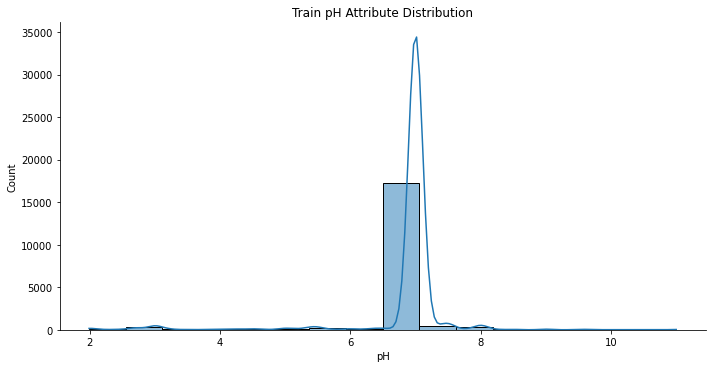

In [40]:
# Train PH Attribute Distribution
sns.displot(train_df['pH'], aspect=2, height=5, kde=True).set(title="Train pH Attribute Distribution")

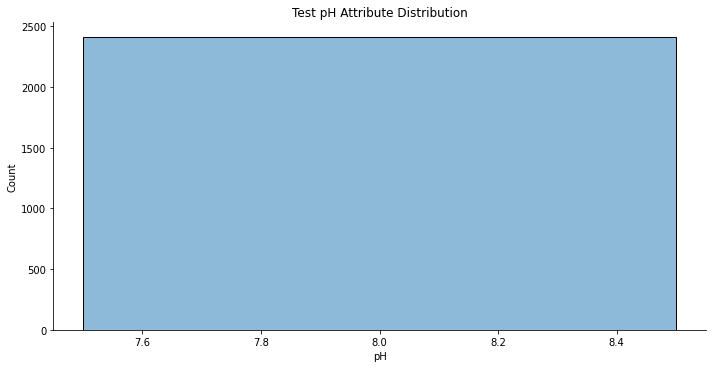

In [41]:
# Test Set pH value Distribution
sns.displot(test_df['pH'], aspect=2, height=5, kde=True).set(title="Test pH Attribute Distribution")

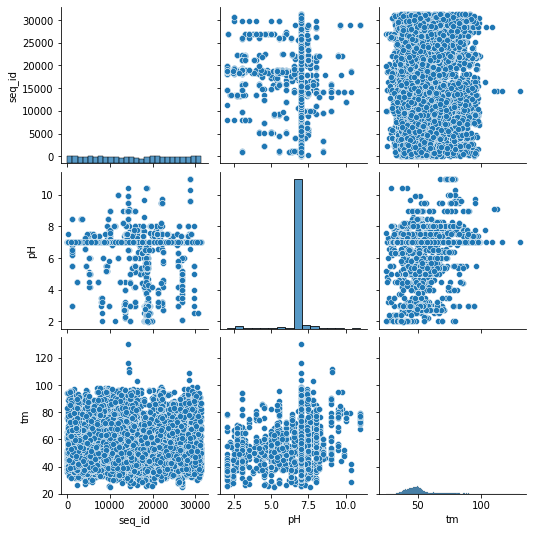

In [42]:
# Pair Plot on Train Set
sns.pairplot(train_df)

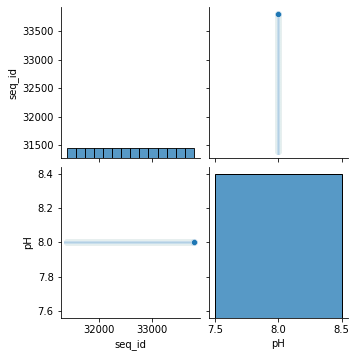

In [43]:
sns.pairplot(test_df)

In [44]:
# Imputing Missing values in PH attribute
imputer = SimpleImputer(strategy="mean")
train_df["pH"] = imputer.fit_transform(train_df[["pH"]]).ravel()
val_df["pH"] = imputer.transform(val_df[["pH"]]).ravel()

In [45]:
# # Dropping the Missing Values
# train_df = train_df.dropna(axis=0)
# val_df = val_df.dropna(axis=0)

In [46]:
train_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                    0
data_source         640
tm                    0
dtype: int64

In [47]:
val_df.isnull().sum()

seq_id                0
protein_sequence      0
pH                    0
data_source         340
tm                    0
dtype: int64

# Feature Engineering

In [48]:
# Create Protein Sequence Length as Feature
train_df["protein_length"] = train_df["protein_sequence"].apply(lambda x: len(x))
val_df["protein_length"] = val_df["protein_sequence"].apply(lambda x: len(x))
test_df["protein_length"] = test_df["protein_sequence"].apply(lambda x: len(x))

In [49]:
def return_amino_acid_df(df):    
    # Feature Engineering on Train Data
    search_amino=['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']
    for amino_acid in search_amino:
         df[amino_acid]=df['protein_sequence'].str.count(amino_acid,re.I)
    return df

In [50]:
# Get the Amino Acid DataFrame for Train, Val and Test Set
train_df = return_amino_acid_df(train_df)
val_df = return_amino_acid_df(val_df)
test_df = return_amino_acid_df(test_df)

In [53]:
#from protlearn.features import length, entropy, aaindex1, atc, aac, ctd

#train_df['entropy'] = train_df["protein_sequence"].apply(lambda x: entropy(x))
#val_df['entropy'] = val_df["protein_sequence"].apply(lambda x: entropy(x))
#test_df['entropy'] = test_df["protein_sequence"].apply(lambda x: entropy(x))

In [54]:
# Dropping Unnecessary Columns
train_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
val_df.drop(columns=["protein_sequence", "seq_id", "data_source"], inplace=True)
test_df.drop(columns=["seq_id", "protein_sequence", "data_source"], inplace=True)

In [55]:
train_df.head(5)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
12058,7.0,46.6,124,6,1,3,10,3,12,1,...,3,6,9,8,7,6,8,13,1,7
2381,7.0,78.9,304,22,0,22,24,15,15,2,...,12,12,14,12,8,18,25,31,4,11
6381,7.0,36.9,304,15,4,22,23,11,16,4,...,5,12,12,15,13,29,14,20,2,13
10739,7.0,36.2,792,50,14,52,64,38,59,19,...,17,29,19,29,56,62,36,52,8,18
21911,7.0,61.5,96,11,0,7,5,0,3,0,...,3,4,5,6,5,11,11,5,0,0


In [56]:
val_df.head(5)

,pH,tm,protein_length,A,C,D,E,F,G,H,...,M,N,P,Q,R,S,T,V,W,Y
16502,3.0,52.0,164,15,3,10,8,5,10,1,...,5,12,3,5,13,5,11,9,3,6
843,7.0,52.2,362,20,13,19,22,16,24,9,...,6,16,19,10,17,39,19,27,2,12
5731,7.0,57.6,732,41,5,39,46,21,48,24,...,9,31,84,34,64,75,36,33,16,17
8663,7.0,48.1,640,55,7,49,52,28,33,17,...,16,18,46,33,30,54,19,35,6,19
27605,7.0,53.1,909,54,9,45,66,45,38,23,...,34,40,35,39,33,80,57,50,21,33


In [57]:
test_df.head(10)

,pH,protein_length,A,C,D,E,F,G,H,I,...,M,N,P,Q,R,S,T,V,W,Y
0,8,221,22,4,15,8,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
1,8,221,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
2,8,220,22,4,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
3,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,8,13,6,6
4,8,221,22,4,15,7,11,19,0,6,...,0,19,17,13,3,18,8,13,6,6
5,8,221,22,4,15,7,10,20,0,6,...,0,19,17,13,3,18,8,13,6,6
6,8,221,22,4,15,7,10,19,1,6,...,0,19,17,13,3,18,8,13,6,6
7,8,221,22,4,15,7,10,19,0,7,...,0,19,17,13,3,18,8,13,6,6
8,8,221,23,4,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6
9,8,221,22,5,15,7,10,19,0,6,...,0,19,17,13,3,18,7,13,6,6


In [58]:
# Seperate Dependent and Independent Variables
X_train = train_df.drop(columns=["tm"])
y_train = train_df["tm"]

X_val = val_df.drop(columns=["tm"])
y_val = val_df["tm"]

X_test = test_df

# Modelling

In [59]:
def for_display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

random_grid={'max_depth':list(np.arange(10, 100, step=10)),
              'n_estimators':np.arange(10, 500, step=50),
              'max_features':randint(1,7),
              'min_samples_leaf':randint(1,4),
              'min_samples_split':np.arange(2, 10, step=2)
         }

rf = RandomForestRegressor(random_state = 42)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 40, scoring='neg_mean_absolute_error', 
                              cv =3, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

# Fit the random search model
rf_random.fit(X_train,y_train)


for_display(rf_random)

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] END max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=360; total time=   9.3s
[CV] END max_depth=70, max_features=4, min_samples_leaf=1, min_samples_split=6, n_estimators=360; total time=  17.4s
[CV] END max_depth=70, max_features=4, min_samples_leaf=1, min_samples_split=6, n_estimators=360; total time=  17.3s
[CV] END max_depth=70, max_features=4, min_samples_leaf=1, min_samples_split=6, n_estimators=360; total time=  17.4s
[CV] END max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=360; total time=   9.1s
[CV] END max_depth=50, max_features=4, min_samples_leaf=3, min_samples_split=4, n_estimators=210; total time=   9.2s
[CV] END max_depth=50, max_features=4, min_samples_leaf=3, min_samples_split=4, n_estimators=210; total time=   9.5s
[CV] END max_depth=50, max_features=2, min_samples_leaf=3, min_samples_split=6, n_estimators=360; total time=   9.5s
[C

In [90]:
best_params = {'max_depth': 75, 'max_features': 20, 'min_samples_leaf': 1, 'min_samples_split': 6, 'n_estimators': 3600}
rf_best = RandomForestRegressor(**best_params,random_state = 42)
rf_best.fit(X_train,y_train)

RandomForestRegressor(max_depth=75, max_features=20, min_samples_split=6,
                      n_estimators=3600, random_state=42)

# Model Performance

In [88]:
# Correlation Value
y_pred_train = rf_best.predict(X_train)
y_pred_val = rf_best.predict(X_val)
print("Training Correlation Value: {}".format(spearmanr(y_pred_train, y_train)))
print("Validation Correlation Value: {}".format(spearmanr(y_pred_val, y_val)))

Training Correlation Value: SpearmanrResult(correlation=0.9468662930612749, pvalue=0.0)
Validation Correlation Value: SpearmanrResult(correlation=0.5745140653004378, pvalue=0.0)


In [86]:
# Checking the performance of the model on Train, Val and Test Set

print("Mean Absolute error on Train data is:{}".format(mean_absolute_error(y_train, y_pred_train)))
print("Mean Absolute error on Val data is:{}".format(mean_absolute_error(y_val, y_pred_val)))

Mean Absolute error on Train data is:2.826888276228765
Mean Absolute error on Val data is:5.657022647733619


# Submission

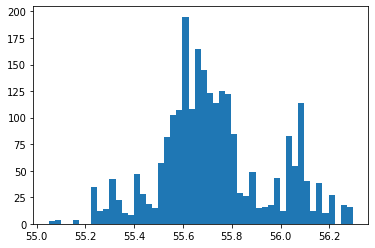

In [73]:
# Let's Do the Submission
y_pred_test = rf_random.predict(X_test)
sub_df["tm"] = y_pred_test
sub_df.to_csv("submission.csv", index=False)
plt.hist(y_pred_test, bins=50)
plt.show()